In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTS

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from transformers import BertModel
from transformers import BertTokenizerFast

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import re
import matplotlib.pyplot as plt
from tqdm import notebook
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# check GPU name
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
#install hugging face transformers
!pip install transformers==3.0.0

# LOADING DATA

In [6]:
dir = "drive/MyDrive/Sentiment-Analysis-Using-BERT/"

In [7]:
df = pd.read_csv(dir + 'Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df['text'].sample(5)

11342    @USAirways PLEASE improve your phone system! Going through multiple prompts &amp; menus just to be told to call back Late Flightr = MAJOR FAIL
10129                                                  @USAirways Mellani B. and whole team in Columbia SC are absolute superstars. Incredibly helpful.
3932                                                    @united ok, I have that, pretty sure I had it before too but will wait and see what happens....
2844                     @united thank you thank you thank you for contacting me. Thank you for the offer of a $1000 travel certificate #unitedairlines
3880                                                                                @united right... Are you guys charging for the air we breathe next?
Name: text, dtype: object

In [9]:
df['airline_sentiment'].value_counts(normalize = True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

# PREPROCESSING

## TEXT CLEANING

In [10]:
def preprocessor(text):
  text = text.lower()
  text = re.sub(r'@[A-Za-z0-9]+','',text)           
  text = re.sub(r'#[A-Za-z0-9]+','',text)         
  text = re.sub(r'http\S+', '', text)  
  tokens = text.split()
  return " ".join(tokens)

In [11]:
df['clean_text']= df['text'].apply(preprocessor)

In [12]:
df['clean_text'].sample(5)

3879                            1627 to montego bay going back to gate bc 1person was late flight? awful service for all of who came on time!!
9273                                                              has me on my toes whether i'm going to make my flight back to boston tonight
13917                              you all should really be ashamed. the entire business class cabin is empty and almost all of first class...
7244     not an issue but i think training &amp; information would help. great ppl but service needs to switch from individual to group better
9605                                                                                                 we take late flight to a whole new level!
Name: clean_text, dtype: object

In [13]:
text   = df['clean_text'].values
labels = df['airline_sentiment'].values

## PREPARING INPUT AND OUTPUT DATA

In [14]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [15]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [16]:
labels

array([1, 2, 1, ..., 1, 0, 1])

Text(0.5, 1.0, 'Histogram: Length of sentences')

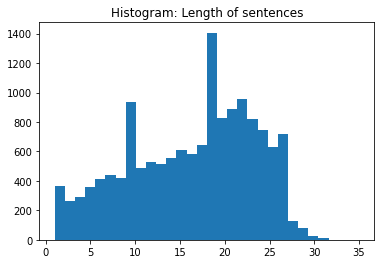

In [17]:
# compute no. of words in each tweet
num = [len(i.split()) for i in text]

plt.hist(num, bins = 30)

plt.title("Histogram: Length of sentences")

In [18]:
max_len = 25

In [19]:
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

In [20]:
sent_id = []

for i in notebook.tqdm(range(len(text))):
  encoded_sent = tokenizer.encode(text[i], add_special_tokens = True, max_length = max_len, truncation = True, pad_to_max_length='right')    
  sent_id.append(encoded_sent)

In [21]:
print("Text Sequence:", text[0])

Text Sequence: what said.


In [22]:
print("Integer Sequence:", sent_id[0])

Integer Sequence: [101, 2054, 2056, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
print("Tokenized Text:", tokenizer.convert_ids_to_tokens(sent_id[0]))

Tokenized Text: ['[CLS]', 'what', 'said', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [24]:
print("Decoded String:", tokenizer.decode(sent_id[0]))

Decoded String: [CLS] what said. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [25]:
attention_masks = []

for sent in sent_id:
  att_mask = [int(token_id > 0) for token_id in sent]
  attention_masks.append(att_mask)

In [26]:
print("Attention Mask:", attention_masks[0])

Attention Mask: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## TRAIN / VAL SPLIT

In [27]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sent_id, labels, random_state = 2018, test_size = 0.1, stratify = labels)

In [28]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state = 2018, test_size = 0.1, stratify = labels)

## DATALOADERS

In [29]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [30]:
batch_size = 32

In [31]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

In [32]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

validation_sampler = SequentialSampler(validation_data)

validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

# MODEL

In [33]:
# download bert pretrained model
bert = BertModel.from_pretrained('bert-base-uncased')

In [34]:
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [35]:
iterator = iter(train_dataloader)

sent_id, mask, target = iterator.next()
print(sent_id.shape)

outputs = bert(sent_id, attention_mask = mask)

hidden_states = outputs[0]

CLS_hidden_state = outputs[1]

print("Shape of Hidden States:", hidden_states.shape)
print("Shape of CLS Hidden State:", CLS_hidden_state.shape)

torch.Size([32, 25])
Shape of Hidden States: torch.Size([32, 25, 768])
Shape of CLS Hidden State: torch.Size([32, 768])


In [36]:
for param in bert.parameters():
    param.requires_grad = False

## ARCHITECTURE


In [37]:
class classifier(nn.Module):

    def __init__(self, bert):
      
      super(classifier, self).__init__()

      self.bert = bert 
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,3)
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      
      all_hidden_states, cls_hidden_state = self.bert(sent_id, attention_mask = mask)
      
      x = self.fc1(cls_hidden_state)
      x = self.relu(x)
      x = self.dropout(x)

      x = self.fc2(x)
      
      x = self.softmax(x)

      return x

In [38]:
model = classifier(bert)
model = model.to(device)

In [39]:
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [40]:
sent_id = sent_id.to(device)
mask = mask.to(device)
target = target.to(device)

outputs = model(sent_id, mask)

print(outputs)

tensor([[-1.0938, -1.0489, -1.1561],
        [-1.0836, -1.1062, -1.1062],
        [-0.9441, -1.1411, -1.2327],
        [-1.1285, -1.0217, -1.1504],
        [-1.0603, -1.0389, -1.2046],
        [-1.0095, -1.0990, -1.1961],
        [-0.9808, -1.1164, -1.2123],
        [-0.8995, -1.2148, -1.2158],
        [-0.8978, -1.1168, -1.3273],
        [-1.0286, -1.0889, -1.1844],
        [-0.9775, -1.1245, -1.2074],
        [-0.9305, -1.1662, -1.2238],
        [-1.0546, -1.0754, -1.1696],
        [-1.0785, -1.0754, -1.1434],
        [-0.9998, -1.1366, -1.1675],
        [-0.9918, -1.1101, -1.2054],
        [-1.0685, -1.0182, -1.2200],
        [-1.0494, -1.0624, -1.1900],
        [-1.1654, -1.0302, -1.1048],
        [-1.0744, -1.0637, -1.1605],
        [-1.0509, -1.1198, -1.1269],
        [-1.0854, -1.0554, -1.1578],
        [-0.9014, -1.1838, -1.2452],
        [-0.9858, -1.1221, -1.1998],
        [-0.9909, -1.1609, -1.1535],
        [-1.0214, -1.0889, -1.1929],
        [-1.0039, -1.1448, -1.1543],
 

In [41]:
# no. of trianable parameters
print("The model has "  + str(sum(p.numel() for p in model.parameters() if p.requires_grad)) + " trainable parameters")

The model has 395267 trainable parameters


## OPTIMIZER AND LOSS FUNCTION


In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Text(0.5, 1.0, 'Class Distribution')

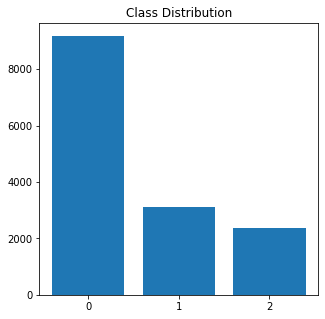

In [43]:
# understandING the class distribution
keys = ['0','1','2']
class_counts = df['airline_sentiment'].value_counts().tolist()
plt.figure(figsize = (5, 5))
plt.bar(keys, class_counts)
plt.title('Class Distribution')

In [44]:
class_weights = compute_class_weight('balanced', np.unique(labels), labels)
print("Class Weights:", class_weights)

Class Weights: [0.53170625 1.57470152 2.06517139]


In [45]:
weights= torch.tensor(class_weights, dtype = torch.float)

weights = weights.to(device)

In [46]:
cross_entropy  = nn.NLLLoss(weight = weights) 

In [47]:
loss = cross_entropy(outputs, target)
print("Loss:", loss)

Loss: tensor(1.0770, device='cuda:0', grad_fn=<NllLossBackward>)


In [48]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds = elapsed_rounded))

## TRAINING

In [49]:
def train():
  
  print("\nTraining.....")  
  
  model.train()

  t0 = time.time()

  total_loss, total_accuracy = 0, 0
  
  total_preds=[]
  
  for step, batch in enumerate(train_dataloader):
    
    if step % 40 == 0 and not step == 0:
      
      elapsed = format_time(time.time() - t0)      
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)

    sent_id, mask, labels = batch
    
    model.zero_grad()        

    preds = model(sent_id, mask)

    loss =  cross_entropy(preds, labels)

    total_loss = total_loss + loss.item()

    loss.backward()

    optimizer.step()

    preds = preds.detach().cpu().numpy()

    total_preds.append(preds)

  avg_loss     = total_loss / len(train_dataloader)
  
  #total_preds(no. of batches, size of batch, no. of classes).
  total_preds  = np.concatenate(total_preds, axis=0)
  #total_preds(number of samples, no. of classes)
  
  return avg_loss, total_preds

## EVALUATION

In [50]:
def evaluate():
  
  print("\nEvaluating.....")
  
  model.eval()

  t0 = time.time()

  total_loss, total_accuracy = 0, 0
  
  total_preds = []

  for step, batch in enumerate(validation_dataloader):
    
    if step % 40 == 0 and not step == 0:
      
      elapsed = format_time(time.time() - t0)
            
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)

    sent_id, mask, labels = batch

    with torch.no_grad():
      
      preds = model(sent_id, mask)

      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  avg_loss = total_loss / len(validation_dataloader) 

  #total_preds(no. of batches, size of batch, no. of classes).
  total_preds  = np.concatenate(total_preds, axis=0)
  #total_preds(number of samples, no. of classes)
  
  return avg_loss, total_preds

## TRAIN MODEL

In [52]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

epochs = 5

for epoch in range(epochs):
     
    print('\n....... epoch {:} / {:} .......'.format(epoch + 1, epochs))
    
    train_loss, _ = train()
    
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), dir + 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")


....... epoch 1 / 5 .......

Training.....
  Batch    40  of    412.    Elapsed: 0:00:02.
  Batch    80  of    412.    Elapsed: 0:00:04.
  Batch   120  of    412.    Elapsed: 0:00:06.
  Batch   160  of    412.    Elapsed: 0:00:08.
  Batch   200  of    412.    Elapsed: 0:00:10.
  Batch   240  of    412.    Elapsed: 0:00:12.
  Batch   280  of    412.    Elapsed: 0:00:14.
  Batch   320  of    412.    Elapsed: 0:00:16.
  Batch   360  of    412.    Elapsed: 0:00:18.
  Batch   400  of    412.    Elapsed: 0:00:20.

Evaluating.....
  Batch    40  of     46.    Elapsed: 0:00:02.

Training Loss: 0.746
Validation Loss: 0.653

....... epoch 2 / 5 .......

Training.....
  Batch    40  of    412.    Elapsed: 0:00:02.
  Batch    80  of    412.    Elapsed: 0:00:04.
  Batch   120  of    412.    Elapsed: 0:00:06.
  Batch   160  of    412.    Elapsed: 0:00:08.
  Batch   200  of    412.    Elapsed: 0:00:10.
  Batch   240  of    412.    Elapsed: 0:00:12.
  Batch   280  of    412.    Elapsed: 0:00:14.
  Ba

## EVALUATE MODEL

In [53]:
model.load_state_dict(torch.load(dir + 'saved_weights.pt'))

<All keys matched successfully>

In [54]:
valid_loss, preds = evaluate()
print(valid_loss)


Evaluating.....
  Batch    40  of     46.    Elapsed: 0:00:02.
0.6527562782816265


In [55]:
y_pred = np.argmax(preds,axis=1)

In [56]:
print(classification_report(validation_labels, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       918
           1       0.58      0.65      0.61       310
           2       0.71      0.77      0.74       236

    accuracy                           0.77      1464
   macro avg       0.72      0.75      0.73      1464
weighted avg       0.78      0.77      0.78      1464



# INFERENCE

In [57]:
def predict(sen):
  sen = preprocessor(sen)
  
  sen = tokenizer.encode(sen, add_special_tokens = True, max_length = max_len, truncation = True, pad_to_max_length='right')    
  mask = [int(token_id > 0) for token_id in sen]

  sen = torch.tensor(sen).unsqueeze(0)
  mask = torch.tensor(mask).unsqueeze(0)
  
  sen = sen.to(device)
  mask = mask.to(device)
  
  preds = model(sen, mask).detach().cpu()
  preds = np.argmax(F.softmax(preds, dim=1).numpy(), axis = 1)
  preds = le.classes_[preds][0]
  
  print(preds)

In [58]:
predict("The flight was an hour late and the in cabin service was not woth the money")

negative


In [59]:
predict("Flight was on time and smooth, also the in cabin services excellent")

positive


In [68]:
predict("The food in the flight was not that good")

negative
